In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Perturbation Simulation

Simulation of single-cell RNA sequencing datasets and datasets of perturbation of their cells.

## Telegraph model of gene expression

The gene switches between on and off states, transcribing molcules of X when on which then degrade:

$ G_{off} \underset{k_{off}}{\stackrel{k_{on}}{\rightleftharpoons}} G_{on} $

$ G_{on} \stackrel{k_{tx}}\longrightarrow G_{on} + X $

$ X \stackrel{k_{deg}}\longrightarrow \varnothing $

However, we only observe the number of molecules of X, not the state of the gene, giving "mariginal observations" from $\bar{p}(x)$ and not $p(x,0)$ or $p(x,1)$ over the state space $ (x,g) \in \mathbb{N} \times \{0,1\} $ where g = 0 corresponds to $ G_{off} $ and g = 1 to $ G_{on} $

The stationary distribution (marginal) of the telegraph model is Beta-Poisson, which can be used to simulate data:

$ x \vert \rho \sim \text{Poisson}\left(\frac{k_{tx}}{k_{deg}}\rho\right) \quad \rho \sim \text{Beta}\left(\frac{k_{on}}{k_{deg}}, \frac{k_{off}}{k_{deg}}\right)$

## Simulation

In [2]:
rng = np.random.default_rng(77)

k_on = 0.6127212372282483
k_off = 0.13833103062834834
k_tx = 6.393810952803462
k_deg = 1.0

NO sig. perturbation

k_on = 0.5257439851418697
k_off = 0.14285365471379957
k_tx = 6.982445387872002
k_deg = 1.0



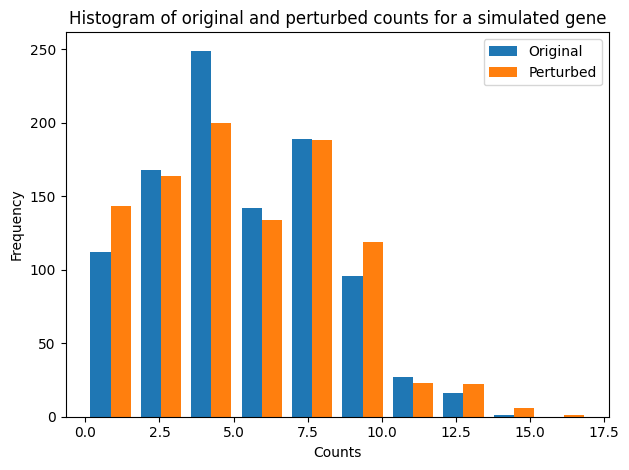

In [25]:
# sample parameter values
k_on = 10 ** rng.uniform(-1, 1)
k_off = 10 ** rng.uniform(-1, 1)
k_tx = 10 ** rng.uniform(-1, 1)
k_deg = 1.0
print(f"k_on = {k_on}\nk_off = {k_off}\nk_tx = {k_tx}\nk_deg = {k_deg}\n")

# sample from stationary dist p(x)
rho = rng.beta(k_on / k_deg, k_off / k_deg, size=1000)
x = rng.poisson(rho * k_tx / k_deg, size=1000)

# ignore capture efficiency

# sample from perturbation options
pert = rng.integers(3)
match pert:
    # up
    case 0:
        mult = rng.uniform(1.5, 5)
        choice = rng.integers(7)
        match choice:
            case 0:
                print(f"k_on UP by {mult}\n")
                k_on *= mult
            case 1:
                print(f"k_off DOWN by {mult}\n")
                k_off /= mult
            case 3:
                print(f"k_tx UP by {mult}\n")
                k_tx *= mult
            case 4:
                print(f"k_on UP, k_off DOWN by {mult}\n")
                k_on *= mult
                k_off /= mult
            case 5:
                print(f"k_on, k_tx UP by {mult}\n")
                k_on *= mult
                k_tx *= mult
            case 6:
                print(f"k_tx UP, k_deg DOWN by {mult}\n")
                k_off /= mult
                k_tx *= mult
            case 7:
                print(f"k_on, k_tx UP, k_off DOWN by {mult}\n")
                k_on *= mult
                k_off /= mult
                k_tx *= mult

    # none
    case 1:
        print("NO sig. perturbation\n")
        sig = 0.1
        k_on = max(rng.normal(k_on, sig * k_on), 0.1)
        k_off = max(rng.normal(k_off, sig * k_off), 0.1)
        k_tx = max(rng.normal(k_tx, sig * k_tx), 0.1)

    # down
    case 2:
        mult = rng.uniform(1.5, 5)
        choice = rng.integers(7)
        match choice:
            case 0:
                print(f"k_on DOWN by {mult}\n")
                k_on /= mult
            case 1:
                print(f"k_off UP by {mult}\n")
                k_off *= mult
            case 3:
                print(f"k_tx DOWN by {mult}\n")
                k_tx /= mult
            case 4:
                print(f"k_off UP, k_on DOWN by {mult}\n")
                k_on /= mult
                k_off *= mult
            case 5:
                print(f"k_on, k_tx DOWN by {mult}\n")
                k_on /= mult
                k_tx /= mult
            case 6:
                print(f"k_off UP, k_tx DOWN by {mult}\n")
                k_off *= mult
                k_tx /= mult
            case 7:
                print(f"k_off UP, k_on, k_tx DOWN by {mult}\n")
                k_on /= mult
                k_off *= mult
                k_tx /= mult

print(f"k_on = {k_on}\nk_off = {k_off}\nk_tx = {k_tx}\nk_deg = {k_deg}\n")

# sample from stationary dist p(x)
rho = rng.beta(k_on / k_deg, k_off / k_deg, size=1000)
x_pert = rng.poisson(rho * k_tx / k_deg, size=1000)

# ignore capture efficiency

plt.hist([x, x_pert], label=["Original", "Perturbed"]);
#plt.hist(x, alpha=0.5, label="Original");
#plt.hist(x_pert, alpha=0.5, label="Perturbed");
plt.xlabel("Counts")
plt.ylabel("Frequency")
plt.title("Histogram of original and perturbed counts for a simulated gene")
plt.legend()
plt.tight_layout()
plt.show()

### Dataset simulation

In [36]:
def perturbed_dataset_simulation(genes=2500, cells=5000, printing=False):
    '''
    Simulate an original and perturbed set of parameters for each gene
    For each set and each cell sample to produce 2 datasets of counts
    '''
    # settings
    min_k = 0.01
    sig = 0.5

    # dataframes
    parameters_original = pd.DataFrame(index=[f"gene_{i}" for i in range(genes)], columns=['k_on', 'k_off', 'k_tx', 'k_deg'])
    parameters_perturbed = pd.DataFrame(index=[f"gene_{i}" for i in range(genes)], columns=['k_on', 'k_off', 'k_tx', 'k_deg'])
    counts_original = pd.DataFrame(index=[f"gene_{i}" for i in range(genes)], columns=[f"original_cell_{j}" for j in range(cells)])
    counts_perturbed = pd.DataFrame(index=[f"gene_{i}" for i in range(genes)], columns=[f"perturbed_cell_{j}" for j in range(cells)])

    # for each gene
    for i in range(genes):

        # Simulate original parameters 
        k_on = 10 ** rng.uniform(-2, 2)
        k_off = 10 ** rng.uniform(-2, 2)
        k_tx = 10 ** rng.uniform(-2, 2)
        k_deg = 1.0

        # store
        parameters_original.iloc[i] = [k_on, k_off, k_tx, k_deg]

        # for each cell sample counts from stationary dist p(x)
        rho = rng.beta(k_on / k_deg, k_off / k_deg, size=cells)
        x = rng.poisson(rho * k_tx / k_deg, size=cells)
        
        # store
        counts_original.iloc[i] = x

        # Simulate perturbation of parameters
        pert = rng.integers(3)
        match pert:
            # up
            case 0:
                mult = rng.uniform(1.5, 5)
                choice = rng.integers(7)
                match choice:
                    case 0:
                        if printing: print(f"k_on UP by {mult}\n")
                        k_on *= mult
                    case 1:
                        if printing: print(f"k_off DOWN by {mult}\n")
                        k_off /= mult
                    case 3:
                        if printing: print(f"k_tx UP by {mult}\n")
                        k_tx *= mult
                    case 4:
                        if printing: print(f"k_on UP, k_off DOWN by {mult}\n")
                        k_on *= mult
                        k_off /= mult
                    case 5:
                        if printing: print(f"k_on, k_tx UP by {mult}\n")
                        k_on *= mult
                        k_tx *= mult
                    case 6:
                        if printing: print(f"k_tx UP, k_deg DOWN by {mult}\n")
                        k_off /= mult
                        k_tx *= mult
                    case 7:
                        if printing: print(f"k_on, k_tx UP, k_off DOWN by {mult}\n")
                        k_on *= mult
                        k_off /= mult
                        k_tx *= mult

            # none
            case 1:
                if printing: print("NO sig. perturbation\n")

            # down
            case 2:
                mult = rng.uniform(1.5, 5)
                choice = rng.integers(7)
                match choice:
                    case 0:
                        if printing: print(f"k_on DOWN by {mult}\n")
                        k_on /= mult
                    case 1:
                        if printing: print(f"k_off UP by {mult}\n")
                        k_off *= mult
                    case 3:
                        if printing: print(f"k_tx DOWN by {mult}\n")
                        k_tx /= mult
                    case 4:
                        if printing: print(f"k_off UP, k_on DOWN by {mult}\n")
                        k_on /= mult
                        k_off *= mult
                    case 5:
                        if printing: print(f"k_on, k_tx DOWN by {mult}\n")
                        k_on /= mult
                        k_tx /= mult
                    case 6:
                        if printing: print(f"k_off UP, k_tx DOWN by {mult}\n")
                        k_off *= mult
                        k_tx /= mult
                    case 7:
                        if printing: print(f"k_off UP, k_on, k_tx DOWN by {mult}\n")
                        k_on /= mult
                        k_off *= mult
                        k_tx /= mult

        # no matter the 'main' perturbation choice, additionally perturbe parameters via gaussian
        k_on = max(rng.normal(k_on, sig * k_on), min_k)
        k_off = max(rng.normal(k_off, sig * k_off), min_k)
        k_tx = max(rng.normal(k_tx, sig * k_tx), min_k)

        # store
        parameters_perturbed.iloc[i] = [k_on, k_off, k_tx, k_deg]

        # for each cell sample counts from stationary dist p(x)
        rho = rng.beta(k_on / k_deg, k_off / k_deg, size=cells)
        x = rng.poisson(rho * k_tx / k_deg, size=cells)

        # store
        counts_perturbed.iloc[i] = x

    # combined count information for DEseq
    counts_combined = pd.DataFrame(index=[f"gene_{i}" for i in range(genes)], columns=[f"original_{j}" for j in range(cells)] + [f"perturbed_{i}" for i in range(cells)])
    counts_combined = pd.concat([counts_original, counts_perturbed], axis=1)

    # column data information for DEseq (each cell labelled original or perturbed)
    column_data = pd.DataFrame(index=[f"original_cell_{j}" for j in range(cells)] + [f"perturbed_cell_{i}" for i in range(cells)], columns=["status"])
    column_data['status'] = ["original" for j in range(cells)] + ["perturbed" for j in range(cells)]


    return {'parameters_original': parameters_original,
            'parameters_perturbed': parameters_perturbed,
            'counts_original': counts_original,
            'counts_perturbed': counts_perturbed,
            'counts_combined': counts_combined,
            'column_data': column_data}


In [37]:
simulation_dict = perturbed_dataset_simulation(genes=2500, cells=5000)

In [38]:
simulation_dict['parameters_original'].to_csv("Simulated_data/parameters_original.csv")
simulation_dict['parameters_perturbed'].to_csv("Simulated_data/parameters_perturbed.csv")
simulation_dict['counts_original'].to_csv("Simulated_data/counts_original.csv")
simulation_dict['counts_perturbed'].to_csv("Simulated_data/counts_perturbed.csv")
simulation_dict['counts_combined'].to_csv("Simulated_data/counts_combined.csv")
simulation_dict['column_data'].to_csv("Simulated_data/column_data.csv")

In [39]:
simulation_dict['parameters_original'].head()

,k_on,k_off,k_tx,k_deg
gene_0,61.689429,82.14193,0.011013,1.0
gene_1,49.083393,0.071393,0.101789,1.0
gene_2,17.380708,0.014482,5.248278,1.0
gene_3,3.478285,37.959379,0.26537,1.0
gene_4,48.820008,0.063695,0.150419,1.0


In [40]:
simulation_dict['parameters_perturbed'].head()

,k_on,k_off,k_tx,k_deg
gene_0,82.619403,89.000627,0.011931,1.0
gene_1,195.503261,0.061032,0.266888,1.0
gene_2,14.7658,0.01479,4.184903,1.0
gene_3,0.01,13.208788,0.210894,1.0
gene_4,286.313406,0.063769,0.118175,1.0
